# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in three ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.
* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.
* Third, we use the available OhmicBath class 

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qutip
from qutip import (
    basis,
    expect,
    sigmax,
    sigmaz,
)
from qutip.solver.heom import (
    HEOMSolver
)
from qutip.core.environment import BosonicEnvironment,OhmicEnvironment

# Import mpmath functions for evaluation of gamma and zeta
# functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

%matplotlib inline

## System and bath definition

Let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [2]:
# Defining the system Hamiltonian
eps = 0  # Energy of the 2-level system.
Del = 0.2  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [3]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59, but with a factor of $\pi$ moved into the definition of the correlation function):

\begin{align}
C(t) =& \: \frac{1}{\pi}\alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [4]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """The Ohmic bath correlation function as a function of t
    (and the bath parameters).
    """
    corr = (1 / np.pi) * alpha * wc ** (1 - s)
    corr *= beta ** (-(s + 1)) * mp.gamma(s + 1)
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array(
        [
            complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
            for u1, u2 in zip(z1_u, z2_u)
        ],
        dtype=np.complex128,
    )

In [5]:
def ohmic_spectral_density(w, alpha, wc):
    """The Ohmic bath spectral density as a function of w
    (and the bath parameters).
    """
    return w * alpha * np.e ** (-w / wc)

In [6]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """The Ohmic bath power spectrum as a function of w
    (and the bath parameters).
    It is obtained naively using the Fluctuation-Dissipation Theorem
    but, this fails at w=0 where the limit should be taken properly
    """
    bose = (1 / (np.e ** (w * beta) - 1)) + 1
    return w * alpha * np.e ** (-abs(w) / wc) * 2*bose 

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [7]:
Q = sigmaz()
alpha = 3.25
T = 0.5
wc = 1.0
s = 1

And set the cut-off for the HEOM hierarchy:

In [8]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5
# options used for the differential equation solver, while default works it 
# is way slower than using bdf
options = {
    "nsteps":15000, "store_states":True, "rtol":1e-12, "atol":1e-12, "method":"bdf",
}

## Building the HEOM bath by fitting the spectral density

We begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form (J. Chem. Phys. 111, 3365 (1999); https://doi.org/10.1063/1.479669):

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

With the spectral density approximation $J_{\mathrm approx}(w; a, b, c)$ implemented above, we can now perform the fit and examine the results. This can be done quickly using the `SpectralFitter` class, which takes the target spectral density as an array and fits it to the series of **k** underdamped harmonic oscillators with the Meier-Tannor form

In [9]:
w = np.linspace(0, 25, 20000)
J = ohmic_spectral_density(w, alpha, wc)

The `BosonicEnviroment` class has special construtors that can be used to 
create enviroments from arbitrary spectral densities, correlation functions, or
power spectrums. Below we show how to construct a `BosonicEnvironment` from a 
user specified function or array

In [10]:
# From an array
sd_env=BosonicEnvironment.from_spectral_density(J=J,wlist=w)

The resulting `BosonicEnvironment` cannot compute the power spectrum, or 
correlation function because the temperature of the environment has not been 
specified. So the `BosonicEnvironment`  is not fully characterized by the 
parameters provided

In [11]:
# sd_env.power_spectrum(w)

If we want access to these properties we need to provide the Temperature at Initialization

In [12]:
# From an array
sd_env=BosonicEnvironment.from_spectral_density(J=J,wlist=w,T=T)

Now our bosonic environment can compute the Power Spectrum of the spectral 
density provided

In [13]:
# Here we avoid w=0
np.allclose(sd_env.power_spectrum(w[1:]),ohmic_power_spectrum(w[1:],alpha,wc,1/T))

True

Specifying the Temperature also gives the `BosonicEnvironment` access to the 
correlation function

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


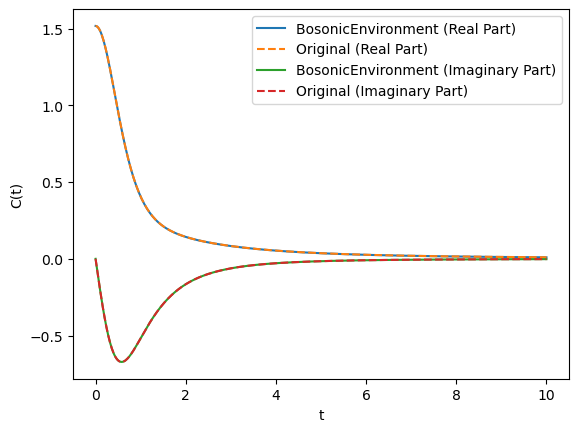

In [14]:
tlist=np.linspace(0,10,500)
plt.plot(tlist,sd_env.correlation_function(tlist),label="BosonicEnvironment (Real Part)")
plt.plot(tlist,ohmic_correlation(tlist,alpha,wc,1/T),"--",label="Original (Real Part)")
plt.plot(tlist,np.imag(sd_env.correlation_function(tlist)),label="BosonicEnvironment (Imaginary Part)")
plt.plot(tlist,np.imag(ohmic_correlation(tlist,alpha,wc,1/T)),"--",label="Original (Imaginary Part)")
plt.ylabel("C(t)")
plt.xlabel("t")
plt.legend()
plt.show()

One important optional parameter is WMax, when passing arrays to the constructor
it defaults to the maximum value of the array, however when passing a function 
we don't need to specify the values on which it is evaluated, and in this case 
WMax needs to be specified, Wmax is the cutoff frequency for which the 
spectral density, or power spectrum has  effectively decayed to zero, after this value the function can be 
considered to be essentialy zero

In [15]:
# From a function
sd_env2=BosonicEnvironment.from_spectral_density(ohmic_spectral_density,T=T,wMax=10*wc,args={"alpha":alpha,"wc":wc})

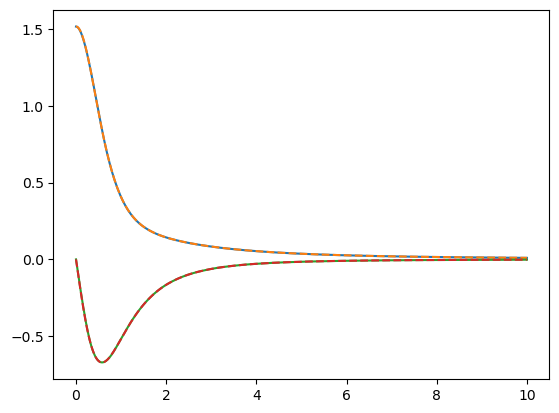

In [16]:
tlist=np.linspace(0,10,500)
plt.plot(tlist,sd_env2.correlation_function(tlist))
plt.plot(tlist,ohmic_correlation(tlist,alpha,wc,1/T),"--")
plt.plot(tlist,np.imag(sd_env2.correlation_function(tlist)))
plt.plot(tlist,np.imag(ohmic_correlation(tlist,alpha,wc,1/T)),"--")

In this example we considered how to obtain a `BosonicEnvironment` from the spectral density, it can be done analogously from the power spectrum or correlation function using the `from_correlation_function` and `from_power_spectrum` methods.

# Obtaining a decaying Exponential description of the environment

In order to carry out our HEOM simulation, we need to express the correlation 
function as a sum of decaying exponentials, that is we need to express it as 

$$C(\tau)= \sum_{k=0}^{N-1}c_{k}e^{-\nu_{k}t}$$

As the correlation function of the environment is tied to it's power spectrum via 
a Fourier transform, such a representation of the correlation function implies a 
power spectrum of the form

$$S(\omega)= \sum_{k}2 Re\left( \frac{c_{k}}{\nu_{k}- i \omega}\right)$$

There are several ways one can obtain such a decomposition, in this tutorial we 
will cover the following approaches:

- Non-Linear Least Squares:
    - On the Spectral Density (`sd`)
    - On the Correlation function (`cf`)
- Methods based on the Prony Polynomial
    - Prony on the correlation function(`prony`)
    - The Matrix Pencil method on the correlation function (`mp`)
    - ESPRIT on the correlation function(`esprit`)
- Methods based on rational Approximations
    - The AAA algorithm on the Power Spectrum (`aaa`)


# Non-Linear Least Squares
## Obtaining an decaying Exponential Description via the spectral density

Once our `BosonicEnvironment` has been constructed, we can obtain a Decaying
exponnetial representation of the environment, via fitting either the spectral
density, power spectrum or the correlation function. 

First we will show how to do it via fitting the spectral density with the 
Nonlinear-Least-Squares method.

The idea here is that we express our arbitrary spectral density as a sum of 
underdamped spectral densities with different coefficients, for which a the
Matsubara decomposition is available. The number of exponents to be kept in the 
Matsubara decomposition of each underdamped spectral density needs to be specified

The output of the fit is a tuple containing an `ExponentialBosonicEnvironment`
and a dictionary that has all the relevant information about the fit performed.
The goodness of the feed is measured via the normalized root mean squared error,
by default the number of terms in the fit increased until the target accuracy 
is reached or the maximum number allowed `Nmax` is reached. The default target
is a  normalized root mean squared error of $5\times 10^{-6}$, if set to None
the fit is performed only with the maximum number of exponents specified



In [17]:
bath, fitinfo = sd_env.approximate("sd",w,Nmax=4)

To obtain an overview of the results of the fit we may take a look at the summary from the ``fitinfo``

In [18]:
print(fitinfo["summary"])

Result of fitting the spectral density with 4 terms: 
 
 Parameters|    a     |    b     |    c 
 1         |-4.41e+00 | 4.30e+00 |3.98e+00
 2         | 6.01e-01 | 1.00e+00 |1.00e-01
 3         | 7.92e+00 | 2.30e+00 |1.00e-01
 4         | 1.06e-02 | 3.07e-01 |1.00e-01
 
A 1-R2 coefficient of  1.38e-06 was obtained for the the spectral density.
The current fit took  29.262844 seconds.


We may see how the number of exponents chosen affects the fit since the approximated functions are available:

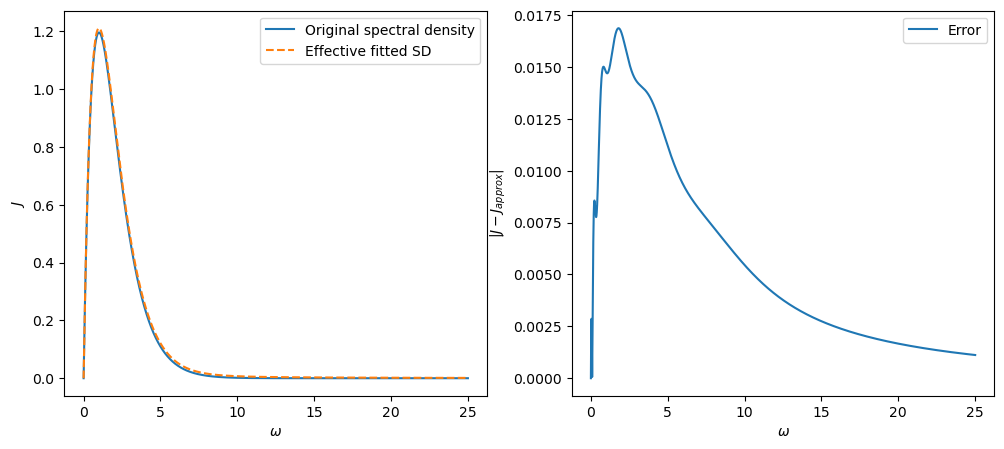

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, bath.spectral_density(w), "--",label="Effective fitted SD")
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$J$')
ax1.legend()

ax2.plot(w, np.abs(J - bath.spectral_density(w)), label="Error")
ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$|J-J_{approx}|$')
ax2.legend()

plt.show()

Here we see a surprisingly large discrepancy in our approximated or effective spectral density. This happens because we are not using enough exponentials from each of the underdamped modes to have an appropiate fit. All modes have the same number of exponents, when not specified it defaults to $1$ which is not enough to model a bath with the temperature considered, let us repeat this with a higher number of exponents.

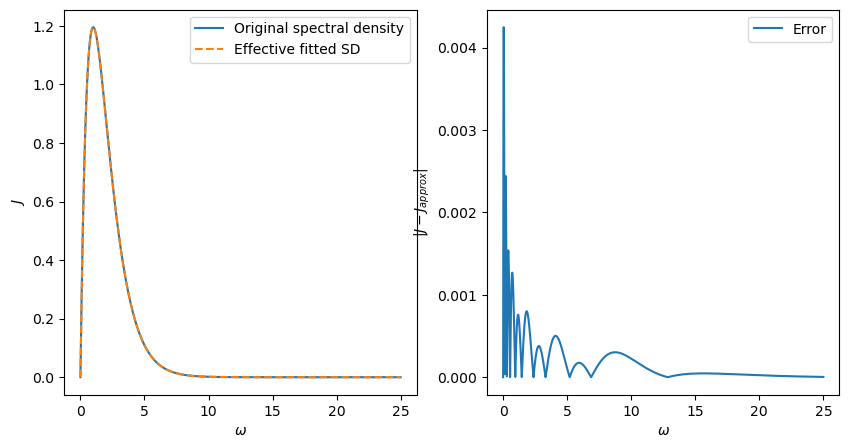

In [20]:
bath, fitinfo = sd_env.approximate("sd",w,Nmax=4,Nk=3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, bath.spectral_density(w), "--",label="Effective fitted SD")
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$J$')
ax1.legend()

ax2.plot(w, np.abs(J - bath.spectral_density(w)), label="Error")
ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$|J-J_{approx}|$')
ax2.legend()

plt.show()

Since the number of exponents increases simulation time one should go with the least amount of exponents that correctly describe the bath properties (Power spectrum, Spectral density and the correlation function).

Let's take a closer look at our last fit by plotting the contribution of each term of the fit:

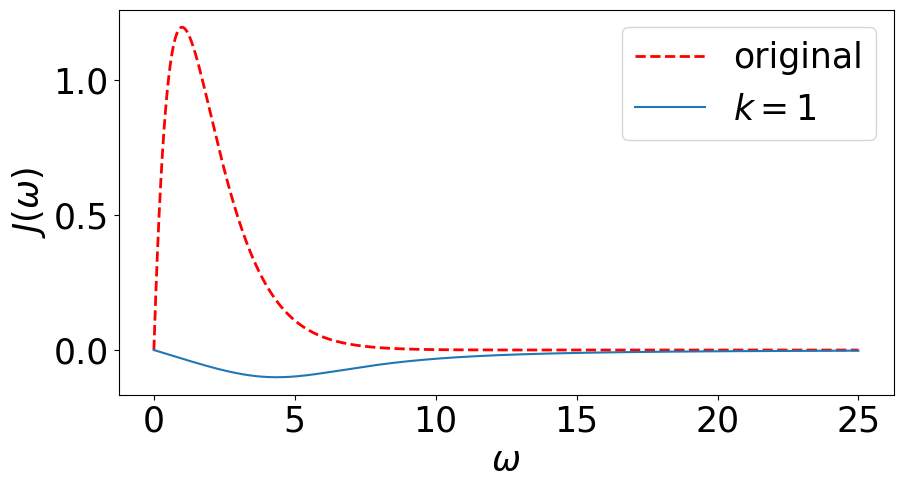

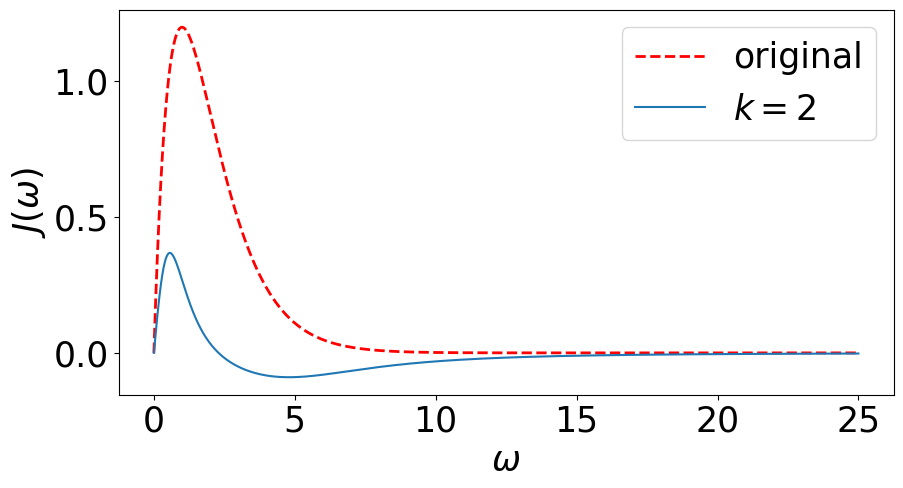

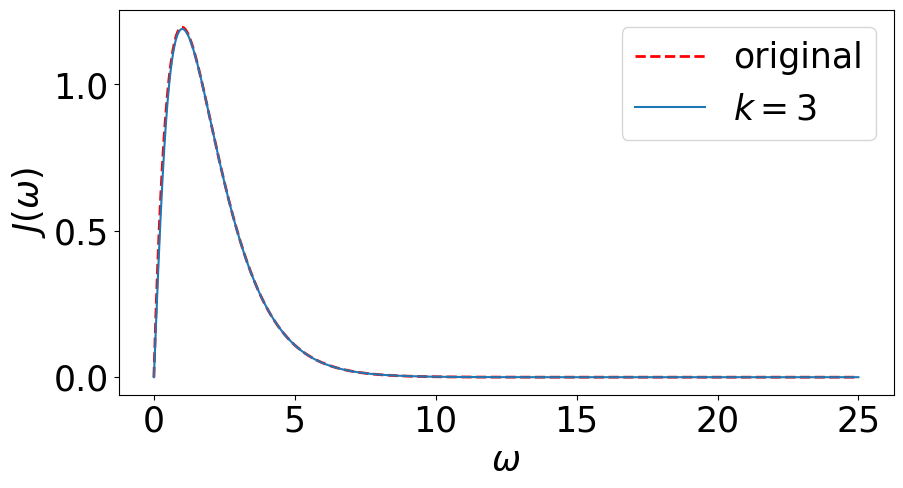

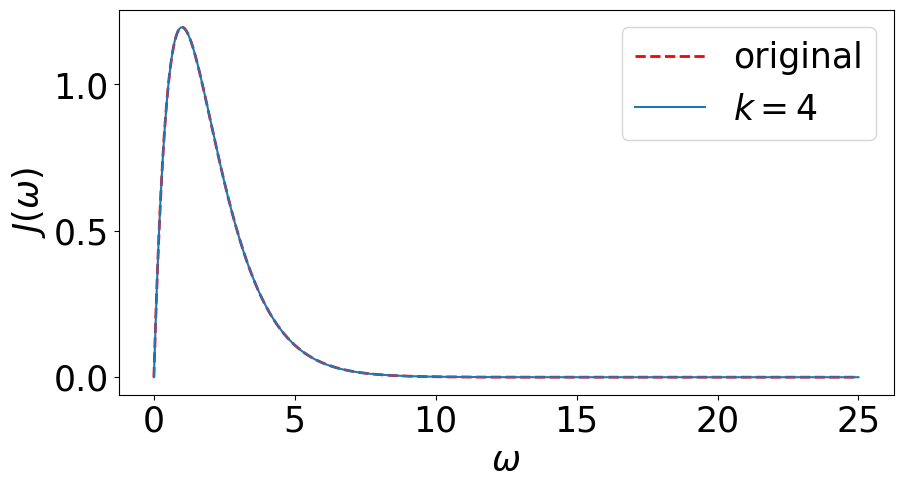

In [21]:
# Plot the components of the fit separately:
plt.rcParams["font.size"] = 25
plt.rcParams["figure.figsize"] = (10, 5)


def plot_fit(func, J, w, lam, gamma, w0):
    """Plot the individual components of a fit to the spectral density.
    and how they contribute to the full fit one by one"""
    total = 0
    for i in range(len(lam)):
        component = func(w, lam[i], gamma[i], w0[i])
        total += component
        plt.plot(w, J, "r--", linewidth=2, label="original")
        plt.plot(w, total, label=rf"$k={i+1}$")
        plt.xlabel(r"$\omega$")
        plt.ylabel(r"$J(\omega)$")
        plt.legend()
        plt.pause(1)
        plt.show()


def plot_fit_components(func, J, w, lam, gamma, w0):
    """Plot the individual components of a fit to the spectral density.
    and how they contribute to the full fit"""
    plt.plot(w, J, "r--", linewidth=2, label="original")
    for i in range(len(lam)):
        component = func(w, lam[i], gamma[i], w0[i])
        plt.plot(w, component, label=rf"$k={i+1}$")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$J(\omega)$")
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.show()


lam=fitinfo["params"][:,0]
gamma=fitinfo["params"][:,1] 
w0 = fitinfo["params"][:,2]
def _sd_fit_model(wlist, a, b, c):
    return (
        2 * a * b * wlist / ((wlist + c)**2 + b**2) / ((wlist - c)**2 + b**2)
    )
plot_fit(_sd_fit_model, J, w, lam, gamma, w0)

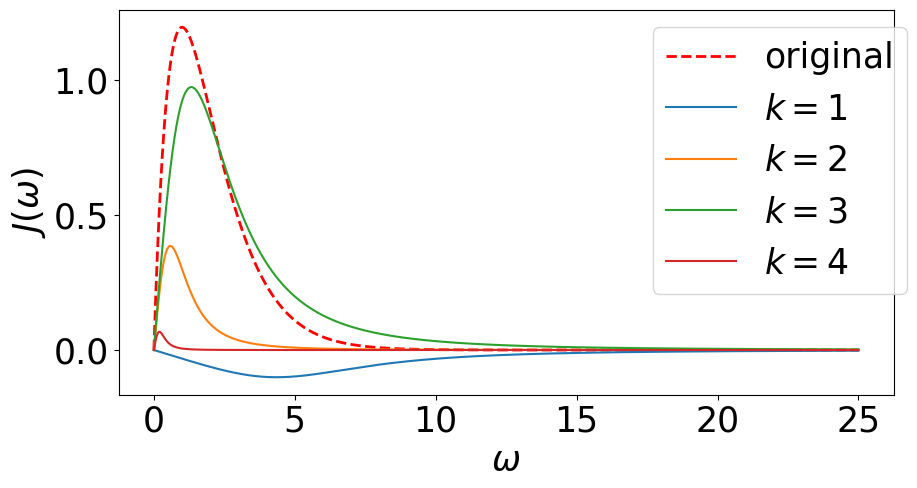

In [22]:
plot_fit_components(_sd_fit_model, J, w, lam, gamma, w0)

And let's also compare the power spectrum of the fit and the analytical spectral density:

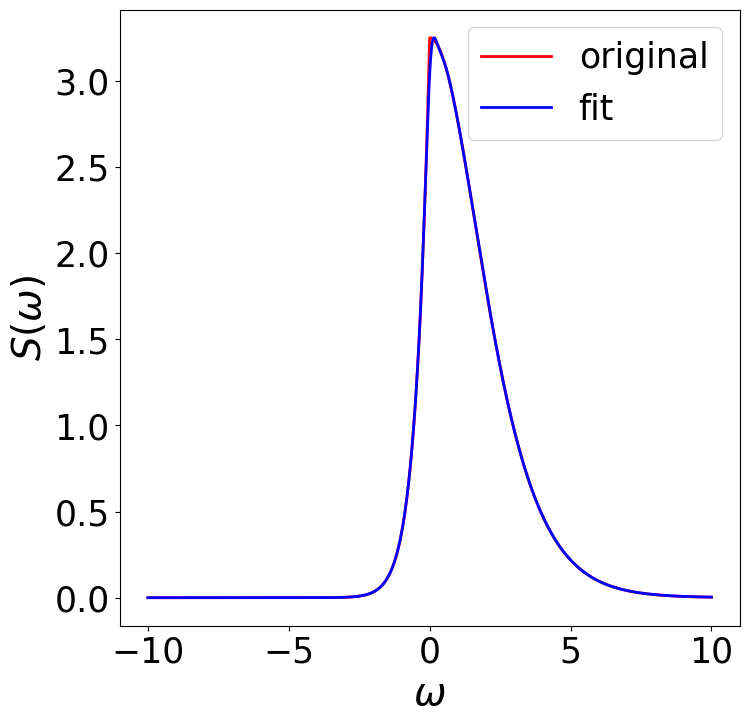

In [23]:
def plot_power_spectrum(alpha, wc, beta, save=True):
    """Plot the power spectrum of a fit against the actual power spectrum."""
    w = np.linspace(-10, 10, 50000)
    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = bath.power_spectrum(w)
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, s_orig, "r", linewidth=2, label="original")
    axes.plot(w, np.real(s_fit), "b", linewidth=2, label="fit")

    axes.set_xlabel(r"$\omega$", fontsize=28)
    axes.set_ylabel(r"$S(\omega)$", fontsize=28)
    axes.legend()

    if save:
        fig.savefig("powerspectrum.eps")


plot_power_spectrum(alpha, wc, 1 / T, save=False)

Now if we want to see the systems's behaviour as we change the number of terms in the fit, we may use this auxiliary function.

In [24]:
def generate_spectrum_results(Q, N, Nk, max_depth):
    """Run the HEOM with the given bath parameters and
    and return the results of the evolution.
    """
    # sigma = 0.0001
    # J_max = abs(max(J, key=abs))
    # lower = [-100*J_max, 0.1*wc,  0.1*wc]
    # guess = [J_max, wc, wc]
    # upper = [100*J_max, 100*wc, 100*wc]
    bath, fitinfo= sd_env.approximate("sd",w,Nmax=N,Nk=Nk,target_rmse=None)#,lower=lower,upper=upper,guess=guess,sigma=sigma)
    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    # This problem is a little stiff, so we use  the BDF method to solve
    # the ODE ^^^
    print(f"Starting calculations for N={N}, Nk={Nk} and max_depth={max_depth} ... ")

    HEOM_spectral_fit = HEOMSolver(
        Hsys,
        (bath,Q),
        max_depth=max_depth,
        options=options,
    )
    results_spectral_fit = HEOM_spectral_fit.run(rho0, tlist)
    return results_spectral_fit

In [25]:
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result,
    measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == "rand":
            axes.plot(
                result.times,
                exp,
                c=np.random.rand(
                    3,
                ),
                label=label,
                **kw,
            )
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

Below we generate results for different convergence parameters (number of terms in the fit, number of matsubara terms, and depth of the hierarchy).  For the parameter choices here, we need a relatively large depth of around '11', which can be a little slow.

Starting calculations for N=1, Nk=1 and max_depth=5 ... 
10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.1%. Run time:   0.26s. Est. time left: 00:00:00:00
40.1%. Run time:   0.31s. Est. time left: 00:00:00:00
50.1%. Run time:   0.38s. Est. time left: 00:00:00:00
60.1%. Run time:   0.42s. Est. time left: 00:00:00:00
70.1%. Run time:   0.45s. Est. time left: 00:00:00:00
80.1%. Run time:   0.49s. Est. time left: 00:00:00:00
90.2%. Run time:   0.53s. Est. time left: 00:00:00:00
100.0%. Run time:   0.57s. Est. time left: 00:00:00:00
Total run time:   0.57s
Starting calculations for N=2, Nk=1 and max_depth=5 ... 
10.0%. Run time:   0.37s. Est. time left: 00:00:00:03
20.0%. Run time:   0.52s. Est. time left: 00:00:00:02
30.1%. Run time:   0.67s. Est. time left: 00:00:00:01
40.1%. Run time:   0.84s. Est. time left: 00:00:00:01
50.1%. Run time:   0.96s. Est. time left: 00:00:00:00
60.1%. Run time:   1.06s. Est. time left: 00:00:00:

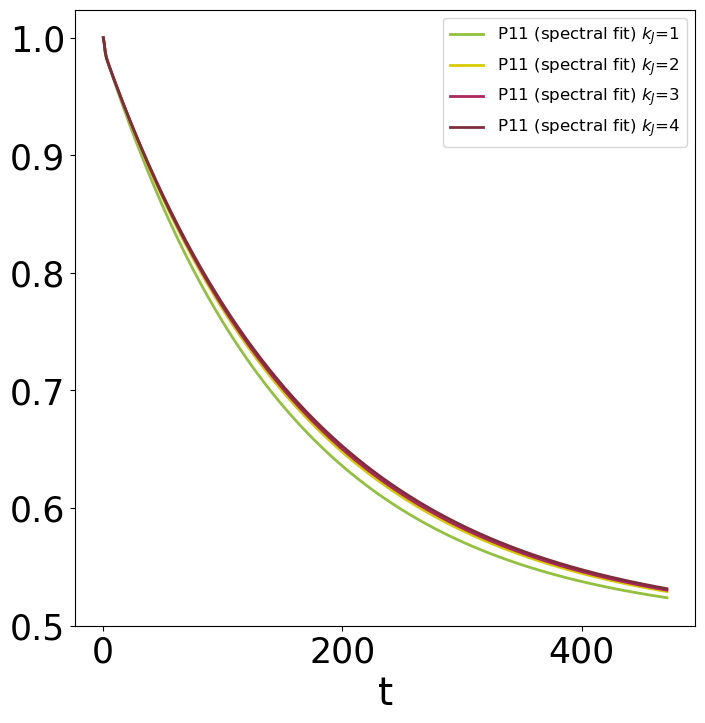

In [26]:
# # Generate results for different number of lorentzians in fit:

results_spectral_fit_pk = [
    generate_spectrum_results(Q, n, Nk=1, max_depth=max_depth) for n in range(1, 5)
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) $k_J$={pk + 1}",
        )
        for pk, result in enumerate(results_spectral_fit_pk)
    ]
);

Starting calculations for N=4, Nk=2 and max_depth=5 ... 
10.0%. Run time:   4.81s. Est. time left: 00:00:00:43
20.0%. Run time:   7.06s. Est. time left: 00:00:00:28
30.1%. Run time:   9.17s. Est. time left: 00:00:00:21
40.1%. Run time:  11.71s. Est. time left: 00:00:00:17
50.1%. Run time:  14.19s. Est. time left: 00:00:00:14
60.1%. Run time:  16.66s. Est. time left: 00:00:00:11
70.1%. Run time:  18.92s. Est. time left: 00:00:00:08
80.1%. Run time:  21.31s. Est. time left: 00:00:00:05
90.2%. Run time:  23.83s. Est. time left: 00:00:00:02
100.0%. Run time:  26.74s. Est. time left: 00:00:00:00
Total run time:  26.74s
Starting calculations for N=4, Nk=3 and max_depth=5 ... 
10.0%. Run time:  15.37s. Est. time left: 00:00:02:18
20.0%. Run time:  25.95s. Est. time left: 00:00:01:43
30.1%. Run time:  35.67s. Est. time left: 00:00:01:23
40.1%. Run time:  45.77s. Est. time left: 00:00:01:08
50.1%. Run time:  54.57s. Est. time left: 00:00:00:54
60.1%. Run time:  62.19s. Est. time left: 00:00:00:

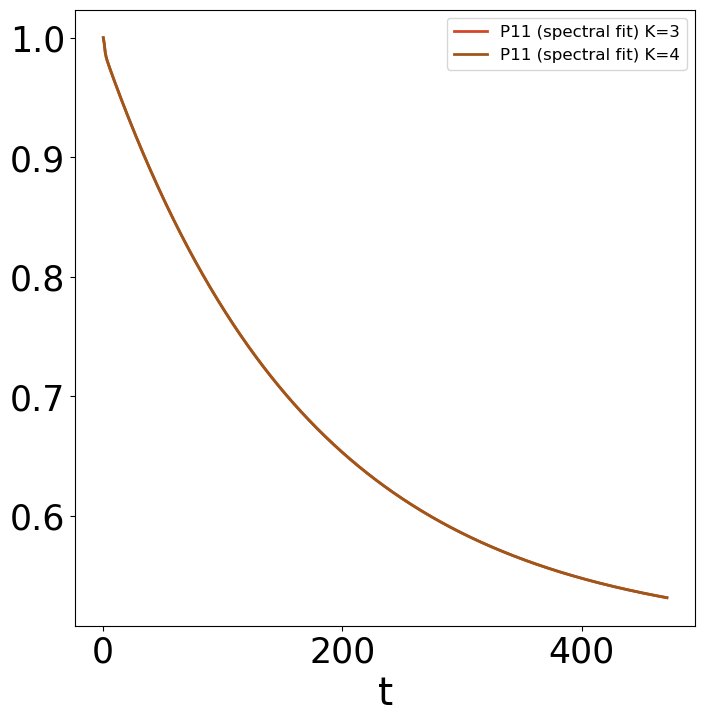

In [27]:
# generate results for different number of Matsubara terms per Lorentzian
# for max number of Lorentzians:

Nk_list = range(2, 4)
results_spectral_fit_nk = [
    generate_spectrum_results(Q, 4, Nk=Nk, max_depth=max_depth) for Nk in Nk_list
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) K={nk+1}",
        )
        for nk, result in zip(Nk_list, results_spectral_fit_nk)
    ]
);

Starting calculations for N=4, Nk=1 and max_depth=2 ... 
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.1%. Run time:   0.13s. Est. time left: 00:00:00:00
40.1%. Run time:   0.17s. Est. time left: 00:00:00:00
50.1%. Run time:   0.19s. Est. time left: 00:00:00:00
60.1%. Run time:   0.22s. Est. time left: 00:00:00:00
70.1%. Run time:   0.25s. Est. time left: 00:00:00:00
80.1%. Run time:   0.27s. Est. time left: 00:00:00:00
90.2%. Run time:   0.29s. Est. time left: 00:00:00:00
100.0%. Run time:   0.32s. Est. time left: 00:00:00:00
Total run time:   0.32s
Starting calculations for N=4, Nk=1 and max_depth=3 ... 
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.1%. Run time:   0.30s. Est. time left: 00:00:00:00
40.1%. Run time:   0.36s. Est. time left: 00:00:00:00
50.1%. Run time:   0.41s. Est. time left: 00:00:00:00
60.1%. Run time:   0.47s. Est. time left: 00:00:00:

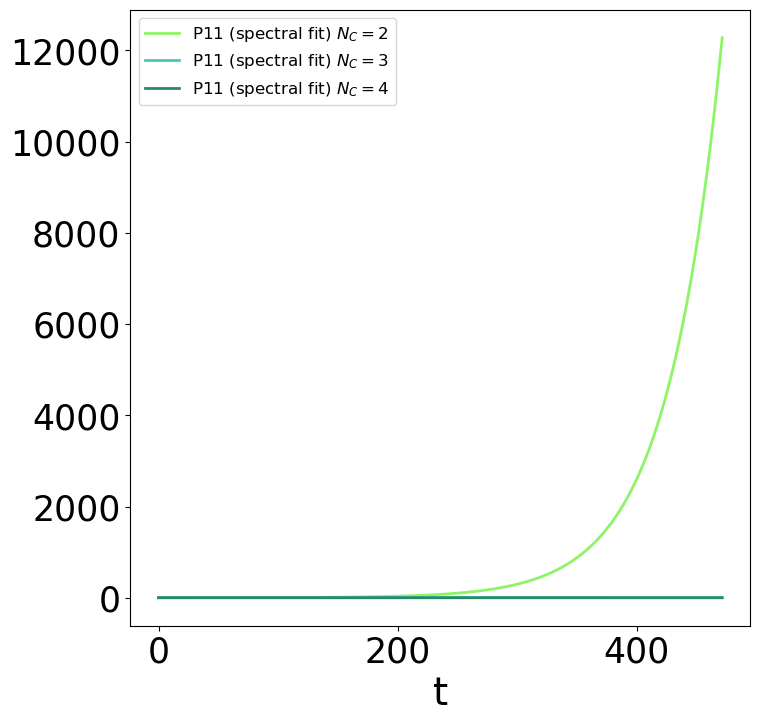

In [28]:
# Generate results for different depths:

Nc_list = range(2, max_depth)
results_spectral_fit_nc = [
    generate_spectrum_results(Q, 4, Nk=1, max_depth=Nc) for Nc in Nc_list
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) $N_C={nc}$",
        )
        for nc, result in zip(Nc_list, results_spectral_fit_nc)
    ]
 );

#### We now combine the fitting and correlation function data into one large plot. Here we define a function to plot everything together

In [29]:
def gen_plots(fs, w, J, t, C, w2, S):
    def plot_cr_fit_vs_actual(t, C, func, axes):
        """Plot the C_R(t) fit."""
        yR = func(t)

        axes.plot(
            t,
            np.real(C),
            "r",
            linewidth=3,
            label="Original",
        )
        axes.plot(
            t,
            np.real(yR),
            "g",
            dashes=[3, 3],
            linewidth=2,
            label="Reconstructed",
        )

        axes.set_ylabel(r"$C_R(t)$", fontsize=28)
        axes.set_xlabel(r"$t\;\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(a)", fontsize=28, transform=axes.transAxes)

    def plot_ci_fit_vs_actual(t, C, func, axes):
        """Plot the C_I(t) fit."""
        yI = func(t)

        axes.plot(
            t,
            np.imag(C),
            "r",
            linewidth=3,
        )
        axes.plot(
            t,
            np.real(yI),
            "g",
            dashes=[3, 3],
            linewidth=2,
        )

        axes.set_ylabel(r"$C_I(t)$", fontsize=28)
        axes.set_xlabel(r"$t\;\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.80, 0.80, "(b)", fontsize=28, transform=axes.transAxes)

    def plot_jw_fit_vs_actual(w, J, axes):
        """Plot the J(w) fit."""
        J_fit = fs.spectral_density(w)

        axes.plot(
            w,
            J,
            "r",
            linewidth=3,
        )
        axes.plot(
            w,
            J_fit,
            "g",
            dashes=[3, 3],
            linewidth=2,
        )

        axes.set_ylabel(r"$J(\omega)$", fontsize=28)
        axes.set_xlabel(r"$\omega/\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(c)", fontsize=28, transform=axes.transAxes)

    def plot_sw_fit_vs_actual(axes):
        """Plot the S(w) fit."""

        # avoid the pole in the fit around zero:
        s_fit = fs.power_spectrum(w2)

        axes.plot(w2, S, "r", linewidth=3)
        axes.plot(w2, s_fit, "g", dashes=[3, 3], linewidth=2)

        axes.set_ylabel(r"$S(\omega)$", fontsize=28)
        axes.set_xlabel(r"$\omega/\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(d)", fontsize=28, transform=axes.transAxes)

    def plot_matsubara_spectrum_fit_vs_actual(t, C):
        """Plot the Matsubara fit of the spectrum ."""
        fig = plt.figure(figsize=(12, 10))
        grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

        plot_cr_fit_vs_actual(
            t,
            C,
            lambda t: fs.correlation_function(t),
            axes=fig.add_subplot(grid[0, 0]),
        )
        plot_ci_fit_vs_actual(
            t,
            C,
            lambda t: np.imag(fs.correlation_function(t)),
            axes=fig.add_subplot(grid[0, 1]),
        )
        plot_jw_fit_vs_actual(
            w,
            J,
            axes=fig.add_subplot(grid[1, 0]),
        )
        plot_sw_fit_vs_actual(
            axes=fig.add_subplot(grid[1, 1]),
        )
        fig.legend(loc="upper center", ncol=2, fancybox=True, shadow=True)

    return plot_matsubara_spectrum_fit_vs_actual(t, C)

#### And finally plot everything together

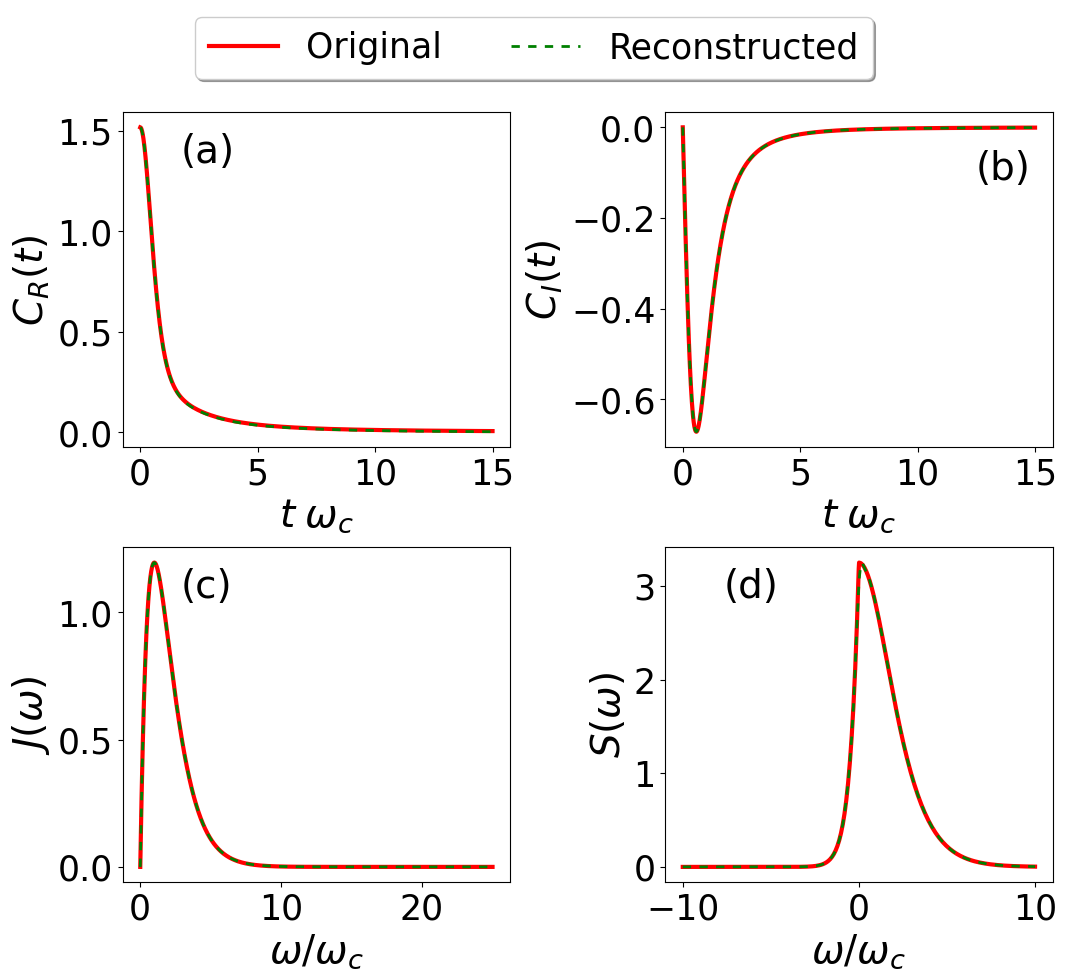

In [30]:
t = np.linspace(0, 15, 1000)
C = ohmic_correlation(t, alpha, wc, 1 / T)
w2 = np.concatenate((-np.linspace(10, 1e-2, 100), np.linspace(1e-2, 10, 100)))
S = ohmic_power_spectrum(w2, alpha, wc, 1 / T)
gen_plots(bath, w, J, t, C, w2, S)

## Obtaining an decaying exponential description via the Correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

Here we fit the real and imaginary parts separately, using the following ansatz 

$$C_R^F(t) = \sum_{i=1}^{k_R} c_R^ie^{-\gamma_R^i t}\cos(\omega_R^i t)$$

$$C_I^F(t) = \sum_{i=1}^{k_I} c_I^ie^{-\gamma_I^i t}\sin(\omega_I^i t)$$

Analogously to the spectral density case, one may use the `approx_by_cf_fit` method, the main difference with respect to the spectral density fit, is that now we are perfoming two fits, one for the real part and another one for the imaginary part

The ansatz used is not good for functions where

$$C_I^F(0) \neq 0$$

The keyword `full_ansatz` which defaults to False. allows for the usage of a 
more general ansatz, the fit however tends to be significantly slower, never
the less it can reach a similar level of accuracy with a lower amount of exponents

When full_ansatz is True. the ansatz used corresponds to 

\begin{align}
\operatorname{Re}[C(t)] = \sum_{k=1}^{N_r} \operatorname{Re}\Bigl[
    (a_k + \mathrm i d_k) \mathrm e^{(b_k + \mathrm i c_k) t}\Bigl]
    ,
\\
\operatorname{Im}[C(t)] = \sum_{k=1}^{N_i} \operatorname{Im}\Bigl[
    (a'_k + \mathrm i d'_k) \mathrm e^{(b'_k + \mathrm i c'_k) t}
    \Bigr].
\end{align}

In [31]:
def generate_corr_results(N, max_depth):
    tlist = np.linspace(0, 30 * np.pi / Del, 600)
    bath_corr ,fitinfo= sd_env.approximate("cf",tlist=t,Ni_max=N,Nr_max=N,maxfev=1e8,target_rsme=None)
    HEOM_corr_fit = HEOMSolver(
        Hsys,
        (bath_corr,Q),
        max_depth=max_depth,
        options=options,
    )

    results_corr_fit = HEOM_corr_fit.run(rho0, tlist)

    return results_corr_fit


# # Generate results for different number of exponentials in fit:
results_corr_fit_pk = [
    print(f"{i + 1}")
    or generate_corr_results(
        i,
        max_depth=max_depth,
    )
    for i in range(1, 4)]

2
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.1%. Run time:   0.06s. Est. time left: 00:00:00:00
50.1%. Run time:   0.07s. Est. time left: 00:00:00:00
60.1%. Run time:   0.09s. Est. time left: 00:00:00:00
70.1%. Run time:   0.10s. Est. time left: 00:00:00:00
80.1%. Run time:   0.11s. Est. time left: 00:00:00:00
90.2%. Run time:   0.13s. Est. time left: 00:00:00:00
100.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.14s
3
10.0%. Run time:   0.82s. Est. time left: 00:00:00:07
20.0%. Run time:   1.36s. Est. time left: 00:00:00:05
30.1%. Run time:   1.84s. Est. time left: 00:00:00:04
40.1%. Run time:   2.31s. Est. time left: 00:00:00:03
50.1%. Run time:   2.81s. Est. time left: 00:00:00:02
60.1%. Run time:   3.31s. Est. time left: 00:00:00:02
70.1%. Run time:   3.81s. Est. time left: 00:00:00:01
80.1%. Run time:   4.31s. Est. time left: 00:00:00:01

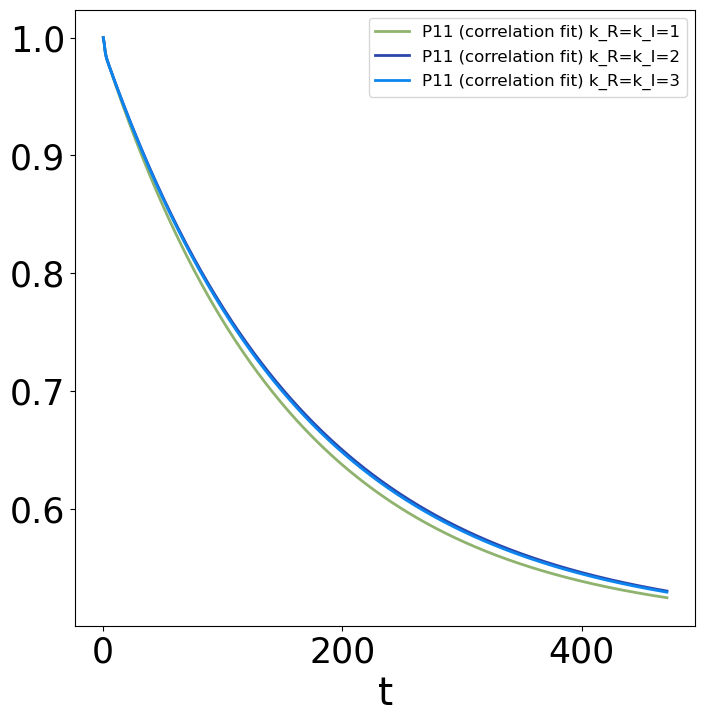

In [32]:
plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (correlation fit) k_R=k_I={pk + 1}",
        )
        for pk, result in enumerate(results_corr_fit_pk)
    ]
);

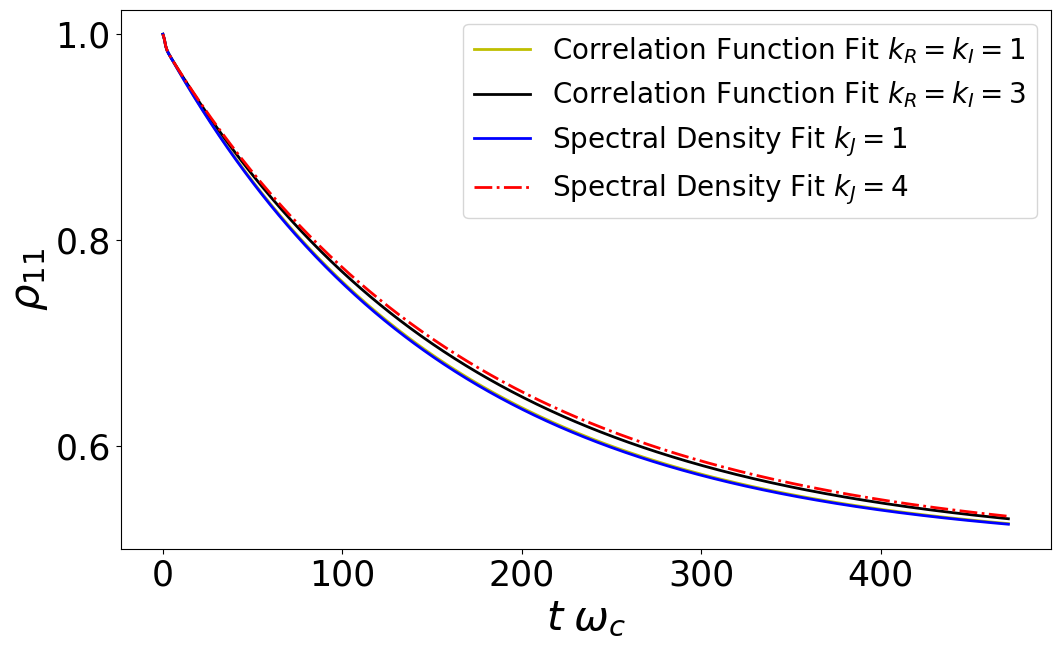

In [33]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations(
    [
        (
            results_corr_fit_pk[0],
            P11p,
            "y",
            "Correlation Function Fit $k_R=k_I=1$",
        ),
        (
            results_corr_fit_pk[2],
            P11p,
            "k",
            "Correlation Function Fit $k_R=k_I=3$",
        ),
        (results_spectral_fit_pk[0], P11p, "b", "Spectral Density Fit $k_J=1$"),
        (results_spectral_fit_pk[3], P11p, "r-.", "Spectral Density Fit $k_J=4$"),
    ],
    axes=axes,
)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r"$\rho_{11}$", fontsize=30)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=30)
axes.legend(loc=0, fontsize=20);

# Using the Ohmic Bath class

 As the ohmic spectrum is popular in the modeling of open quantum systems, it has its own dedicated class, the results above can be reproduced quickly by using the OhmicBath class. This allows for rapid implementation of fitted ohmic baths via the correlation function or spectral density

In [34]:
obs = OhmicEnvironment(T, alpha, wc,s=1)
tlist = np.linspace(0, 30 * np.pi / Del, 600)

Just like the other `BosonicEnvironment` we can obtain a decaying exponential 
representation of the environment via the `approx_by_cf_fit` and 
`approx_by_sd_fit` methods. 

In [35]:
tlist = np.linspace(0, 30 * np.pi / Del, 5000)

Obath, fitinfo = obs.approximate(method="cf",tlist=tlist,Nr_max=4,Ni_max=4,maxfev=1e9,target_rsme=None)
print(fitinfo["summary"])
HEOM_ohmic_corr_fit = HEOMSolver(
    Hsys,
    (Obath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_corr_fit = HEOM_ohmic_corr_fit.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                                    |Result of fitting the imaginary part                                   
the correlation function with 4 terms:                                |of the correlation function with 4 terms:                              
                                                                      |                                                                       
 Parameters|    a     |    b     |    c                               | Parameters|    a     |    b     |    c                                
 1         | 3.24e-01 |-5.34e-01 |3.32e-23                            | 1         |-8.92e+00 |-3.49e-01 |7.57e-04                             
 2         | 2.84e+00 |-2.76e+00 |6.88e-08                            | 2         | 5.44e-01 |-4.30e+00 |4.00e+00                             
 3         |-1.67e+00 |-4.72e+00 |2.77e+00                            | 3         |-1.34e+01 |-1.04e+00 |2.50e-02  

In [36]:
Obath2, fitinfo = obs.approximate(method="sd",wlist=w,Nmax=4,Nk=3)
print(fitinfo["summary"])
tlist = np.linspace(0, 30 * np.pi / Del, 600)
HEOM_ohmic_sd_fit = HEOMSolver(
    Hsys,
    (Obath2,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_sd_fit2 = HEOM_ohmic_sd_fit.run(rho0, tlist)

Result of fitting the spectral density with 4 terms: 
 
 Parameters|    a     |    b     |    c 
 1         |-4.41e+00 | 4.30e+00 |3.98e+00
 2         | 7.92e+00 | 2.30e+00 |1.00e-01
 3         | 6.01e-01 | 1.00e+00 |1.00e-01
 4         | 1.06e-02 | 3.07e-01 |1.00e-01
 
A 1-R2 coefficient of  1.38e-06 was obtained for the the spectral density.
The current fit took  34.405920 seconds.
10.0%. Run time:   7.40s. Est. time left: 00:00:01:06
20.0%. Run time:  12.02s. Est. time left: 00:00:00:47
30.1%. Run time:  17.17s. Est. time left: 00:00:00:39
40.1%. Run time:  21.92s. Est. time left: 00:00:00:32
50.1%. Run time:  26.92s. Est. time left: 00:00:00:26
60.1%. Run time:  32.22s. Est. time left: 00:00:00:21
70.1%. Run time:  39.81s. Est. time left: 00:00:00:16
80.1%. Run time:  46.32s. Est. time left: 00:00:00:11
90.2%. Run time:  60.56s. Est. time left: 00:00:00:06
100.0%. Run time:  74.12s. Est. time left: 00:00:00:00
Total run time:  74.12s


# Methods based on the Prony Polinomial 

The Prony polynomial forms the mathematical foundation for many spectral analysis techniques that estimate frequencies, damping factors, and amplitudes of signals. These methods work by interpreting a given signal as a sum of complex exponentials and deriving a polynomial whose roots correspond to the frequencies or poles of the system.

The methods consider a signal 

$$f(t)=\sum_{k=0}^{N-1} c_{k} e^{-\nu_{k} t} =\sum_{k=0}^{N-1} c_{k} z_{k}^{t}  $$

The $z_{k}$ can be seen as the solution of the Prony Polynomial, which we write in terms of Hankel matrices as 

\begin{align}
    H_{N,M}=V_{N,M-1}(z) diag((c_k)_{k=1}^{M-1}) V_{M,M-1}(z)^{T}
\end{align}

where $V_{N,M}(z)$ is the Vandermonde matrix given by


$$V_{M,N}(z)=\begin{pmatrix} 
1 &1 &\dots &1 \\
z_{1} & z_{2} &\dots & z_{N} \\
z_{1}^{2} & z_{2}^{2} &\dots & z_{N}^{2} \\
\vdots & \vdots & \ddots & \vdots  \\
z_{1}^{M} & z_{2}^{M} &\dots & z_{N}^{M} \\
\end{pmatrix}$$

By obtaining the roots of this polynomial one can obtain the damping rate and the frequency of each mode, the amplitude can lated be obtained by solving the least-squares Vandermonde system given by

$$ V_{N,M}(z)c = f $$

Where $M$ is the length, of the signal, and $f=f(t_{sample})$ is the signal evaluated in the sampling points,is a vector $c = (c_{1}, \dots, c_{N})$.

The main difference between the methods is the way one obtains the roots of the polynomial, typically whether this system is solved or a low rank approximation is found for the polynomial, [this article](https://academic.oup.com/imajna/article-abstract/43/2/789/6525860?redirectedFrom=fulltext) is a good reference, the QuTiP implementations are based on it, and the matlab implementations made available by the authors


## Using the Original Prony Method on the Correlation Function

The method is available via `approx_by_prony`. Compared to the other approaches showed so far. The Prony based methods, shine on their simplicity no information needs to be known about the function, and one just needs to provide the sampling points, and the Number of Exponents one desires

In [37]:
tlist2=np.linspace(0,40,100)

In [38]:
pbath,fitinfo=obs.approximate("prony",tlist2,Nr=4,Ni=4)
print(fitinfo["summary"])
HEOM_ohmic_prony_fit = HEOMSolver(
    Hsys,
    (pbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_prony_fit = HEOM_ohmic_prony_fit.run(rho0, tlist)

4
Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 4 terms:                                          |of the correlation function with 4 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 1.80e-01 | 8.81e-01 | 0.00e+00 |3.74e-19                           | 1         |-1.52e-01 | 8.26e-01 | 0.00e+00 |-6.12e-16                           
 2         | 9.09e-01 | 5.58e-01 | 0.00e+00 |-9.72e-17                          | 2         |-1.86e+00 | 5.61e-01 | 0.00e+00 |2.44e-15                      

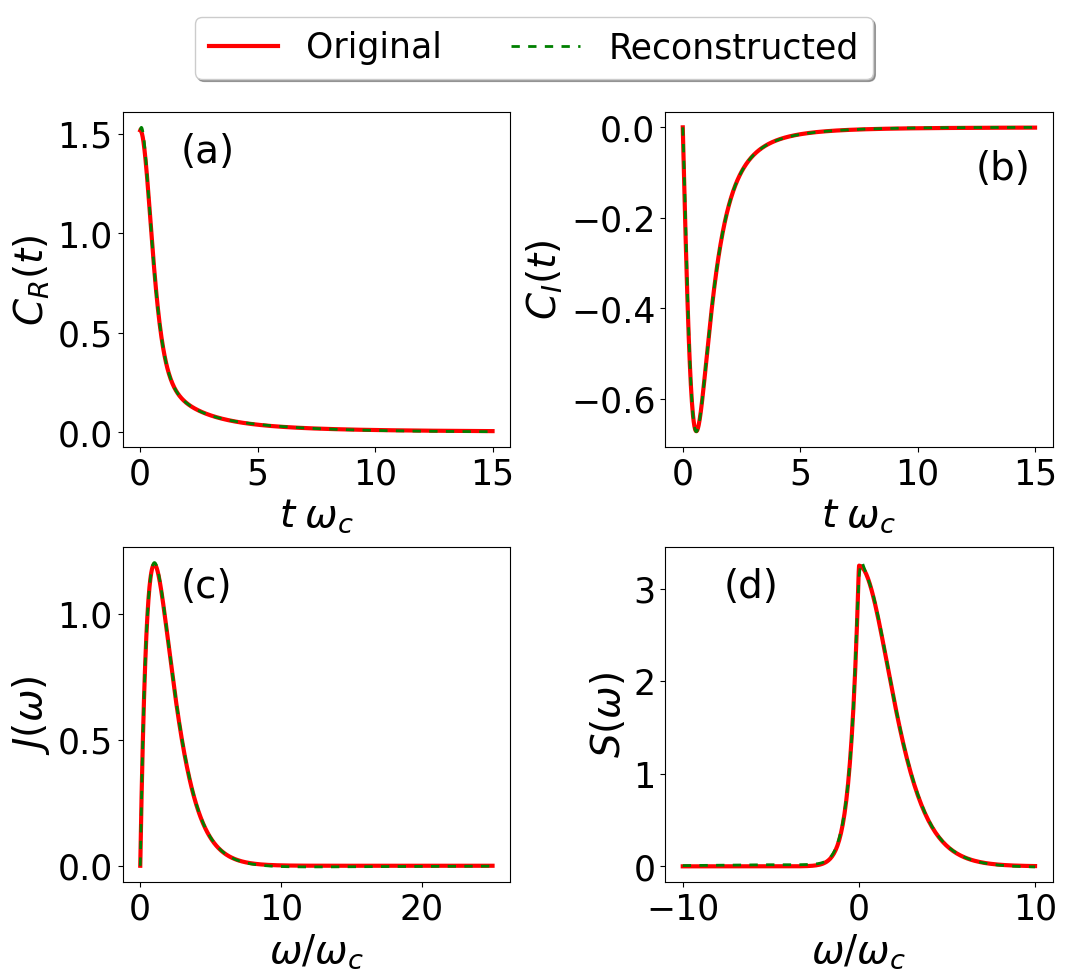

In [39]:
gen_plots(pbath, w, J, t, C, w2, S)

## Using the matrix Pencil Method on the Correlation Function


In [51]:
mpbath,fitinfo=obs.approximate(method="mp",tlist=tlist2,Nr=6,separate=False)
print(fitinfo["summary"])
HEOM_ohmic_mp_fit = HEOMSolver(
    Hsys,
    (mpbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_mp_fit = HEOM_ohmic_mp_fit.run(rho0, tlist)

Result of fitting Correlation Function with 6 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         |-5.55e-02 |-6.25e-03 |-8.46e-02 |-4.36e-01
 2         |-1.32e+00 | 1.45e-01 |-1.18e-01 |1.69e+00
 3         | 3.00e+00 | 3.44e-01 |-6.84e-02 |6.96e-02
 4         | 6.46e-02 | 9.13e-01 | 2.32e-02 |-6.85e-02
 5         | 6.68e-02 | 7.28e-01 | 7.36e-02 |-4.58e-01
 6         |-2.40e-01 | 5.41e-01 | 1.08e-01 |-7.95e-01
 
A 1-R2 coefficient of  3.18e-05-5.05e-06j was obtained for the Correlation Function.
The current fit took  0.218197 seconds.
10.0%. Run time:   5.71s. Est. time left: 00:00:00:51
20.0%. Run time:   9.38s. Est. time left: 00:00:00:37
30.1%. Run time:  13.38s. Est. time left: 00:00:00:31
40.1%. Run time:  17.24s. Est. time left: 00:00:00:25
50.1%. Run time:  21.54s. Est. time left: 00:00:00:21
60.1%. Run time:  25.52s. Est. time left: 00:00:00:16
70.1%. Run time:  29.99s. Est. time left: 00:00:00:12
80.1%. Run time:  33.85s. Est. time left: 00:00:00:08
90.2%

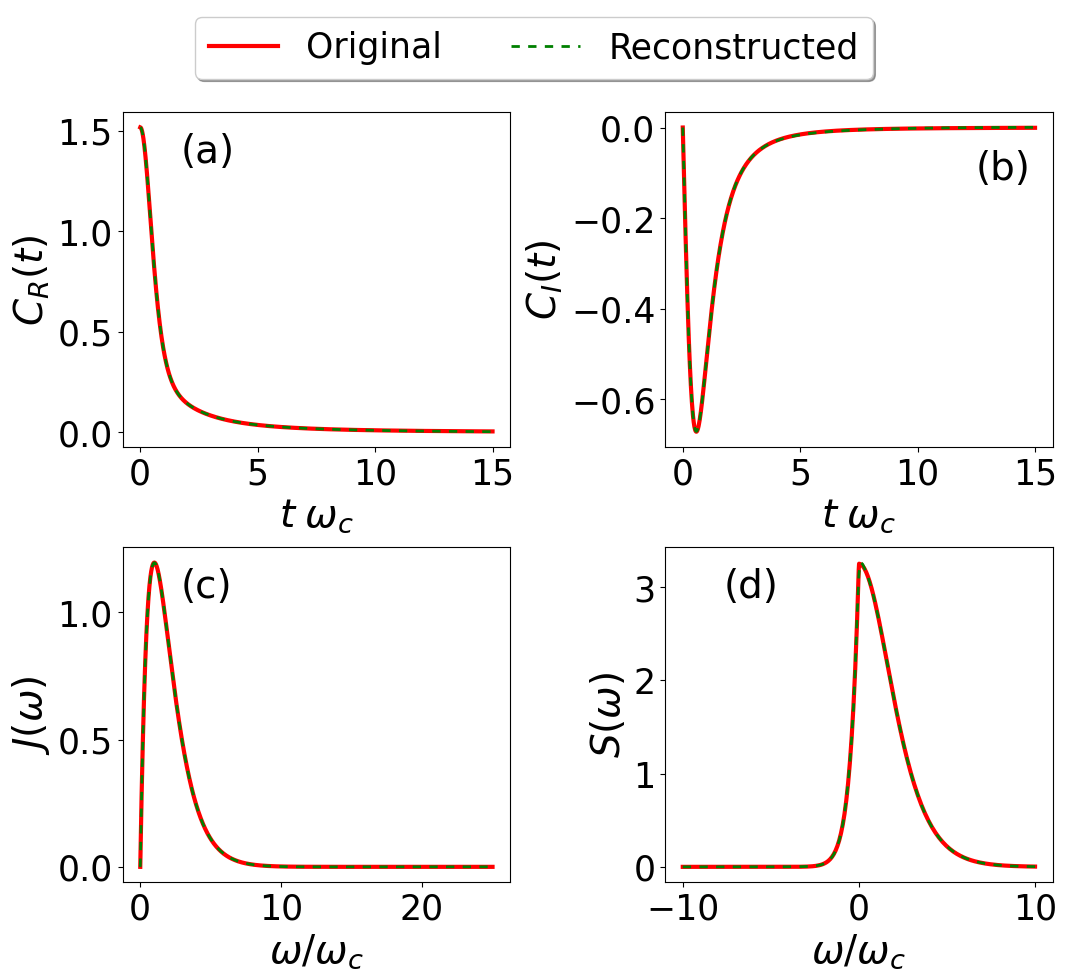

In [52]:
gen_plots(mpbath, w, J, t, C, w2, S)

## Using the ESPRIT Method on the Correlation Function


In [54]:

esbath,fitinfo=obs.approximate("esprit",tlist2,Nr=4,separate=False)
print(fitinfo["summary"])
HEOM_ohmic_es_fit = HEOMSolver(
    Hsys,
    (esbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_es_fit = HEOM_ohmic_es_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         |-5.34e-01 | 1.63e-02 |-1.84e-01 |1.79e-01
 2         | 1.48e+00 | 3.20e-01 |-1.83e-01 |9.86e-01
 3         | 4.75e-01 | 6.57e-01 | 2.51e-02 |-1.12e+00
 4         | 9.95e-02 | 9.08e-01 | 9.49e-03 |-4.96e-02
 
A 1-R2 coefficient of  3.09e-05+9.93e-06j was obtained for the Correlation Function.
The current fit took  0.321152 seconds.
10.0%. Run time:   0.86s. Est. time left: 00:00:00:07
20.0%. Run time:   1.41s. Est. time left: 00:00:00:05
30.1%. Run time:   1.94s. Est. time left: 00:00:00:04
40.1%. Run time:   2.42s. Est. time left: 00:00:00:03
50.1%. Run time:   2.89s. Est. time left: 00:00:00:02
60.1%. Run time:   3.38s. Est. time left: 00:00:00:02
70.1%. Run time:   3.87s. Est. time left: 00:00:00:01
80.1%. Run time:   4.39s. Est. time left: 00:00:00:01
90.2%. Run time:   4.89s. Est. time left: 00:00:00:00
100.0%. Run time:   5.37s. Est. time left: 00:00:00:00
Total 

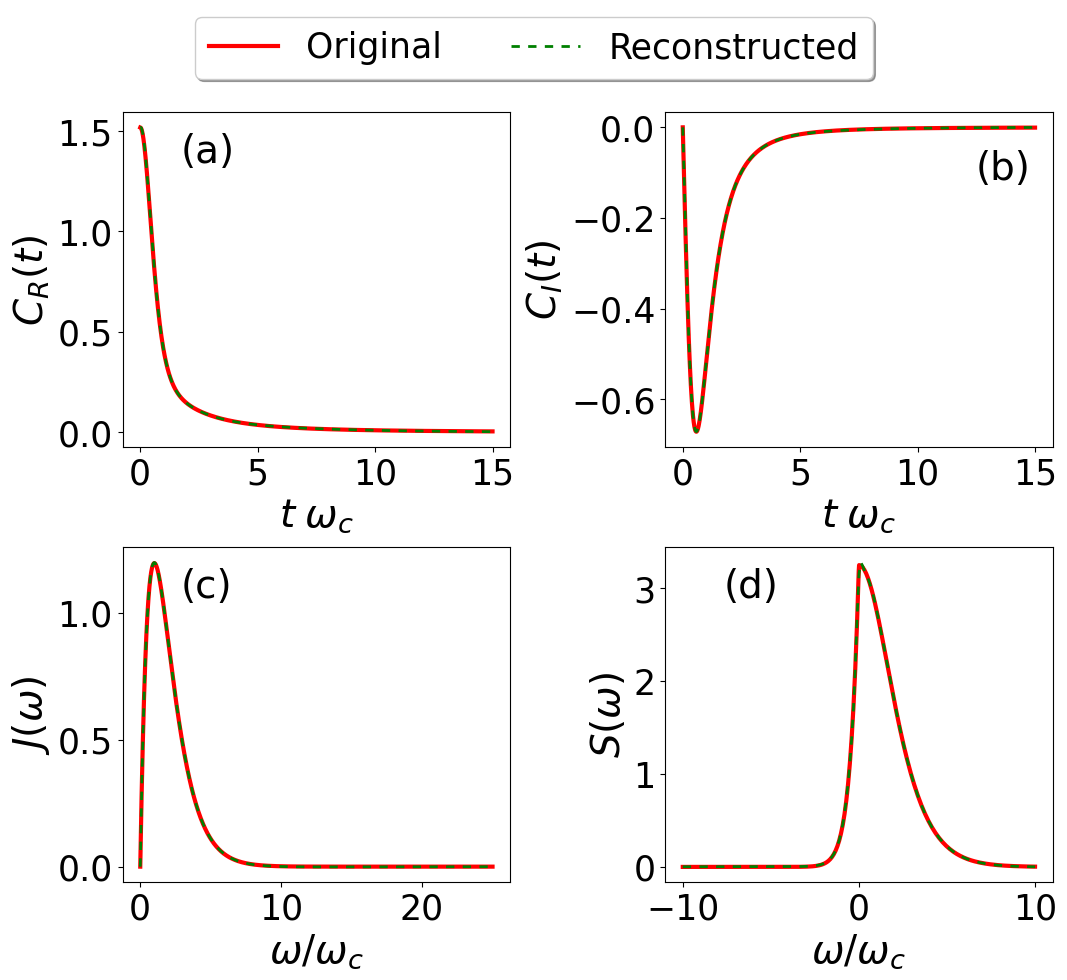

In [55]:
gen_plots(esbath, w, J, t, C, w2, S)

## Using the AAA Algorithm

In [56]:
aaabath,fitinfo=obs.approximate("aaa",np.concatenate((-np.logspace(3,-8,3500),np.logspace(-8,3,3500))),N_max=8,tol=1e-15)
print(fitinfo["summary"])

/home/mcditoos/qutip_gsoc_app/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Result of fitting the spectral density with 6 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         | 2.73e-01 | 1.16e+00 | 2.80e+00 |2.39e+00
 2         | 5.16e-01 |-6.60e-01 | 1.17e+00 |6.45e-01
 3         | 6.73e-01 |-3.62e-01 | 6.98e-01 |1.53e-02
 4         | 3.79e-02 |-1.24e-02 | 1.57e-01 |-1.63e-02
 5         | 1.42e-03 |-5.98e-04 | 2.56e-02 |-5.36e-03
 6         | 9.23e-06 | 3.15e-06 | 1.54e-03 |1.88e-04
 
A 1-R2 coefficient of  1.48e-05 was obtained for the the spectral density.
The current fit took  6.453628 seconds.


In [57]:
HEOM_ohmic_aaa_fit = HEOMSolver(
    Hsys,
    (aaabath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_aaa_fit = HEOM_ohmic_aaa_fit.run(rho0, tlist)

10.0%. Run time:   3.70s. Est. time left: 00:00:00:33
20.0%. Run time:   5.97s. Est. time left: 00:00:00:23
30.1%. Run time:   8.22s. Est. time left: 00:00:00:19
40.1%. Run time:  10.23s. Est. time left: 00:00:00:15
50.1%. Run time:  12.55s. Est. time left: 00:00:00:12
60.1%. Run time:  14.56s. Est. time left: 00:00:00:09
70.1%. Run time:  17.38s. Est. time left: 00:00:00:07
80.1%. Run time:  21.86s. Est. time left: 00:00:00:05
90.2%. Run time:  24.94s. Est. time left: 00:00:00:02
100.0%. Run time:  27.39s. Est. time left: 00:00:00:00
Total run time:  27.40s


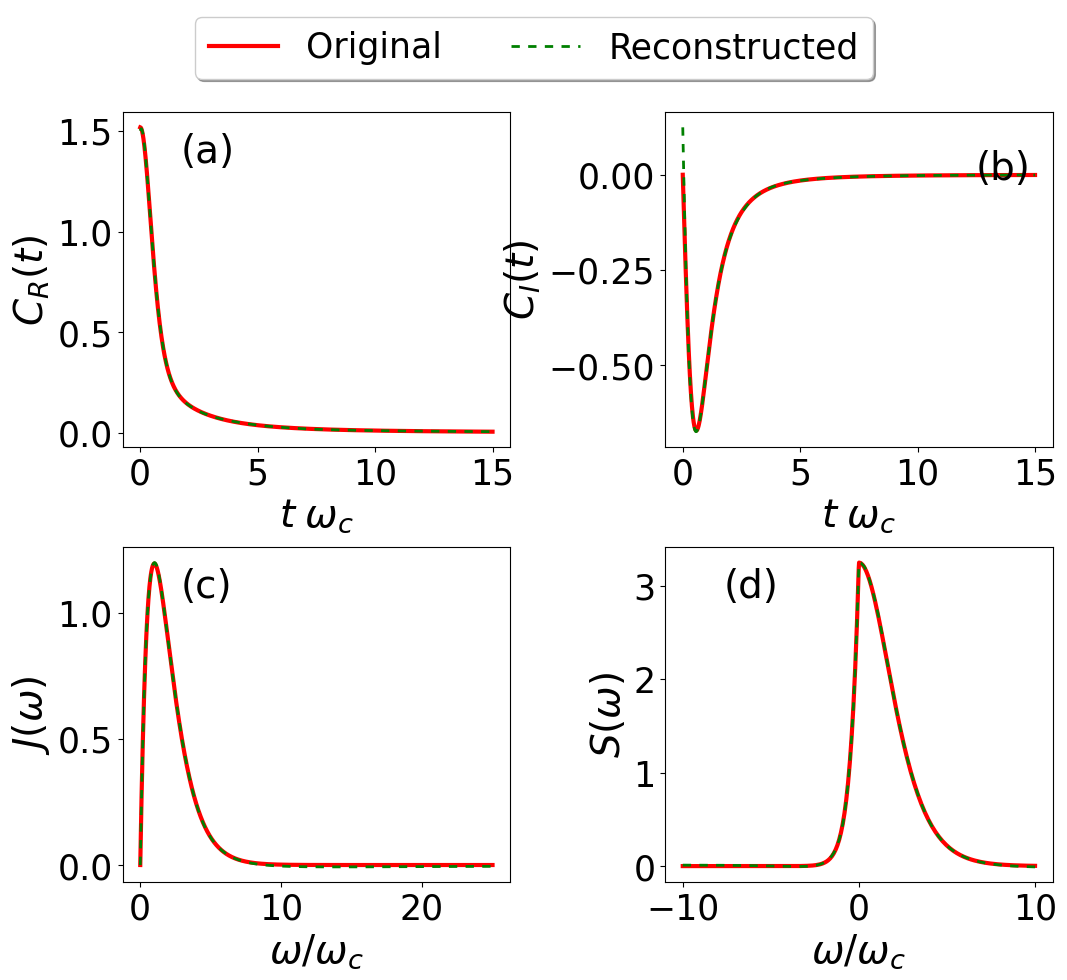

In [58]:
gen_plots(aaabath, w, J, t, C, w2, S)

ESPIRA I

In [59]:
tlist4=np.linspace(0,20,1000)
espibath,fitinfo=obs._approx_by_prony("espira-I",tlist4,Nr=4,Ni=4)
print(fitinfo["summary"])

4
Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 4 terms:                                          |of the correlation function with 4 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 2.18e-01 | 9.37e-01 |-2.85e-02 |1.58e+00                           | 1         | 7.39e-01 | 9.28e-01 | 4.54e-02 |-5.14e-01                           
 2         | 8.01e-01 | 9.44e-01 | 2.50e-02 |-1.54e+00                          | 2         | 9.27e-01 | 9.30e-01 |-4.16e-02 |4.43e-01                      

In [60]:
HEOM_ohmic_espira_fit = HEOMSolver(
    Hsys,
    (espibath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_espira_fit = HEOM_ohmic_espira_fit.run(rho0, tlist)

10.0%. Run time:   0.99s. Est. time left: 00:00:00:08
20.0%. Run time:   1.60s. Est. time left: 00:00:00:06
30.1%. Run time:   2.04s. Est. time left: 00:00:00:04
40.1%. Run time:   2.46s. Est. time left: 00:00:00:03
50.1%. Run time:   2.85s. Est. time left: 00:00:00:02
60.1%. Run time:   3.23s. Est. time left: 00:00:00:02
70.1%. Run time:   3.60s. Est. time left: 00:00:00:01
80.1%. Run time:   3.99s. Est. time left: 00:00:00:00
90.2%. Run time:   4.37s. Est. time left: 00:00:00:00
100.0%. Run time:   4.72s. Est. time left: 00:00:00:00
Total run time:   4.72s


In [64]:
tlist4=np.linspace(0,20,1000)
espibath2,fitinfo=obs._approx_by_prony("espira-II",tlist4,Nr=4,Ni=4)
print(fitinfo["summary"])

4
Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 4 terms:                                          |of the correlation function with 4 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 3.75e-01 | 9.44e-01 | 3.15e-02 |-1.14e+00                          | 1         | 7.81e-01 | 9.30e-01 |-4.43e-02 |4.62e-01                            
 2         | 6.32e-01 | 9.48e-01 |-2.93e-02 |1.10e+00                           | 2         | 8.75e-01 | 9.31e-01 | 4.27e-02 |-4.10e-01                     

In [65]:
HEOM_ohmic_espira_fit2 = HEOMSolver(
    Hsys,
    (espibath2,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_espira2_fit = HEOM_ohmic_espira_fit2.run(rho0, tlist)

10.0%. Run time:   0.71s. Est. time left: 00:00:00:06
20.0%. Run time:   1.36s. Est. time left: 00:00:00:05
30.1%. Run time:   1.70s. Est. time left: 00:00:00:03
40.1%. Run time:   2.05s. Est. time left: 00:00:00:03
50.1%. Run time:   2.41s. Est. time left: 00:00:00:02
60.1%. Run time:   2.78s. Est. time left: 00:00:00:01
70.1%. Run time:   3.14s. Est. time left: 00:00:00:01
80.1%. Run time:   3.49s. Est. time left: 00:00:00:00
90.2%. Run time:   3.84s. Est. time left: 00:00:00:00
100.0%. Run time:   4.18s. Est. time left: 00:00:00:00
Total run time:   4.18s


Finally we plot the dynamics obtained by the different methods

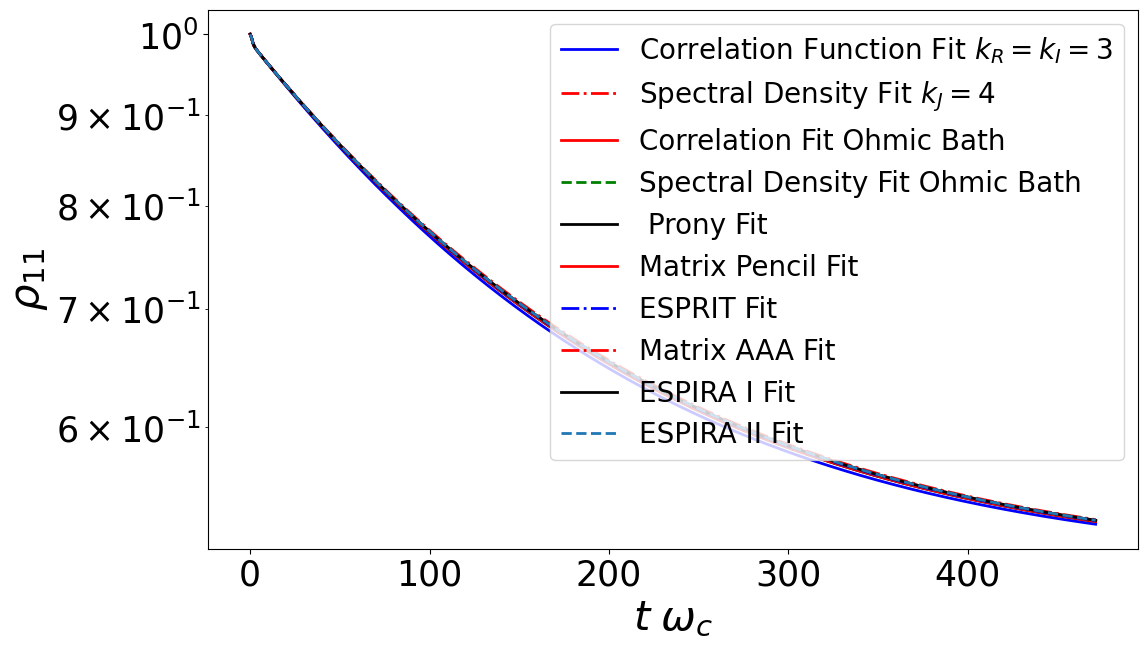

In [69]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations(
    [
        (
            results_corr_fit_pk[2],
            P11p,
            "b",
            "Correlation Function Fit $k_R=k_I=3$",
        ),
        (results_spectral_fit_pk[3], P11p, "r-.", "Spectral Density Fit $k_J=4$"),
        (results_ohmic_corr_fit, P11p, "r", "Correlation Fit Ohmic Bath"),
        (results_ohmic_sd_fit2, P11p, "g--", "Spectral Density Fit Ohmic Bath"),
        (results_ohmic_prony_fit, P11p, "k", " Prony Fit"),
        (results_ohmic_mp_fit, P11p, "r", "Matrix Pencil Fit"),
        (results_ohmic_es_fit, P11p, "b-.", "ESPRIT Fit"),
        (results_ohmic_aaa_fit, P11p, "r-.", "Matrix AAA Fit"),
        (results_ohmic_espira_fit, P11p, "k", "ESPIRA I Fit"),
        (results_ohmic_espira2_fit, P11p, "--", "ESPIRA II Fit"),

    ],
    axes=axes,
)
axes.set_ylabel(r"$\rho_{11}$", fontsize=30)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=30)
axes.legend(loc=0, fontsize=20);
axes.set_yscale("log")

## About

In [70]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+daa7d68
Numpy Version:      1.26.4
Scipy Version:      1.14.1
Cython Version:     3.0.9
Matplotlib Version: 3.9.2
Python Version:     3.12.7
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/mcditoos/qutip_gsoc_app/qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

Please cite QuTiP i

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [73]:

assert np.allclose(
    expect(P11p, results_spectral_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_aaa_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_mp_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_prony_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)

assert np.allclose(
    expect(P11p, results_ohmic_es_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira2_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)